# `microguilds` tutorial
This tutorial will guide you through a use case using a mock mastertable.

## Table of contents
1. [Enrichment analysis](#enrichment-analysis)
2. [Filtering significant nodes](#filter-nodes) 
3. [Clustering the phylogenetic tree](#clustering)
4. [Sample placement](#clustering)
5. [Compute a guilds' k tensor](#compute-ktensors) 
6. Visualize a guilds' k tensor.
7. Interpret the results.

## Import libraries


In [112]:
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import functional_clustering_utils as fcutils
from tqdm import tqdm
from Bio import Phylo


## Setup important variables

In [113]:
# Input
GENE = "mocK"
FILENAME_ENV_DATA = './environmental_data_mock.csv'
FILENAME_TREE = f'./{GENE}_tree.newick'

# Others
MCMAX = 9999

## 1. Enrichment analysis <a class="anchor" id="enrichment-analysis"></a>

### Load environmental data
The environmental table ideally includes a list of organisms and some environmental properties, for example we have included optimal growth temperature and optimal growth pH. However you can also include temperature ranges, or other non-environmental factors that could help clusterize organisms as mobility, whether they are gram-negative/positive and so on.

Also, for best results it is critical that most organisms in the tree match those in the environmental table.

In [114]:
# Load environmental feature matrix
df = pd.read_csv(FILENAME_ENV_DATA, sep=";", encoding='utf8')
ft = df.to_numpy()

# Extract useful info
SPECIES_NAMES = np.array([line[0] for line in ft])
FEATURES_NAMES = np.array([col for col in df.columns])[1:16]
FEATURES_SPECIES = np.array([line[1:16] for line in ft])
NFEATURES = FEATURES_SPECIES.shape[1]

print(f"Succesfully loaded {FILENAME_ENV_DATA}")
df.head(12)

Succesfully loaded ./environmental_data_mock.csv


,organism,temp,pH
0,Vibrio fictivorax,37,6
1,Salmonella imagina,36,7
2,Escherichia ficticola,37,7
3,Mycobacterium fictum,34,7
4,Lactobacillus fictobacter,32,8
5,Bacillus fictilis,34,8
6,Acinetobacter imaginensis,34,8
7,Pseudomonas fictosa,15,4
8,Streptomyces fictivus,14,5
9,Clostridium imaginarium,12,4


### Load the phylogenetic tree

In [118]:
# Compute clade data
TREE = Phylo.read(FILENAME_TREE, 'newick')
data = fcutils.get_clade_data(
    FILENAME_TREE,
    treetype="newick",
    filename_out=None
)

# Extract important variables
clade_ids, clade_lfs, clade_dpt, leaf_names = data

GENUS = np.array([fcutils.get_genus(name) for name in leaf_names])
SPECIES = np.array([fcutils.get_species(name) for name in leaf_names])
NLEAFS = len(leaf_names)
NCLADES = len(clade_ids)
CLADE_NLEAFS = np.array([len(leafs) for leafs in clade_lfs])

Phylo.draw_ascii(TREE)

100%|██████████| 8/8 [00:00<00:00, 4028.14it/s]


Data loaded from ./mocK_tree.newick.
Found data for > 11 leafs,
               > 8 internal nodes.
                  _________ ACCESSION_g_Vibrio_s_fictivorax
  _______________|
 |               |_______ ACCESSION_g_Salmonella_s_imagina
 |
 |          ______________ ACCESSION_g_Escherichia_s_ficticola
 |_________|
 |         |___________ ACCESSION_g_Mycobacterium_s_fictum
 |
_|                _________ ACCESSION_g_Lactobacillus_s_fictobacter
 |_______________|
 |               |     ____ ACCESSION_g_Bacillus_s_fictilis
 |               |____|
 |                    |_______ ACCESSION_g_Acinetobacter_s_imaginensis
 |
 |             ______ ACCESSION_g_Pseudomonas_s_fictosa
 |____________|
              |         ___ ACCESSION_g_Streptomyces_s_fictivus
              |________|
                       |        _____ ACCESSION_g_Clostridium_s_imaginarium
                       |_______|
                               |__ ACCESSION_g_Bacteroides_s_fictus



### Build the features matrix

Find for which organism of the tree we have environmental info in the table, and build a features matrix with in each row an organism, and in each column a feature (environmental or nonenvironmental).

Observe that in this scenario, there is missing environmental data for just one organism.

In [119]:
print("")

FEATURES = np.zeros((NLEAFS, NFEATURES)) * np.nan

# Fill feature matrix of the organisms found in the tree
for idx_sp, species in tqdm(enumerate(SPECIES_NAMES)):
    _speacies_name = species.split(' ')
    for idx_leaf, leaf in enumerate(leaf_names):
        # If "species" is matched to the tree "leaf"
        if (_speacies_name[0] in leaf) and (_speacies_name[1] in leaf):
            FEATURES[idx_leaf, :] = FEATURES_SPECIES[idx_sp, :]

_missing_data = np.sum(np.all(np.isnan(FEATURES), axis=1))
_not_missing_data = FEATURES.shape[0] - _missing_data
idx_missing = np.argwhere(np.all(np.isnan(FEATURES), axis=1))[:, 0]
print(f'\nData obtained for {_not_missing_data} tree entries.')
print(f'Data missing  for {_missing_data} tree entries.')
_ = [print(f"  -[{_:4d}] {GENUS[_]} {SPECIES[_]}") for _ in idx_missing]

11it [00:00, 8577.31it/s]


Data obtained for 11 tree entries.
Data missing  for 0 tree entries.


### Randomize values to compute the enrichment as z-scores.

In [120]:
# Declare accumulators
ZSCORES = np.zeros((NCLADES, NFEATURES)) * np.nan

# Compute randomizations for every internal node
for idx_clade, _leafs in tqdm(enumerate(clade_lfs), total=NCLADES):
    
    # Compute true observed values for each feature
    obs_mean = np.nanmean(FEATURES[_leafs, :], axis=0)

    # Randomize values
    values_mc = np.zeros((MCMAX, NFEATURES))
    for imc in range(MCMAX):
        rr = np.random.permutation(NLEAFS)[:len(_leafs)]
        values_mc[imc, :] = np.nanmean(FEATURES[rr, :], axis=0)

    # Compute and store z-scores
    mc_mean = np.nanmean(values_mc, axis=0)
    mc_std = np.nanstd(values_mc, axis=0)
    mc_std[np.abs(mc_std) <= 1e-8] = np.nan
    ZSCORES[idx_clade, :] = (obs_mean - mc_mean) / mc_std
print("Finished.")

100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

Finished.


### Create some visualization to get a sense of the data.
Observe that we will get clusters based on: high/low temperature and high/low pH.

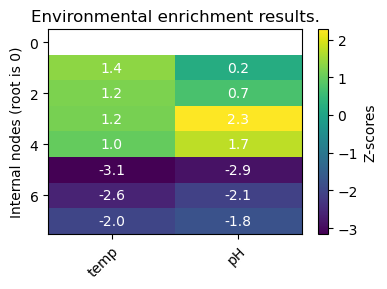

In [121]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100)
im = ax.imshow(ZSCORES, aspect="auto")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(FEATURES_NAMES)), labels=FEATURES_NAMES)
#ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(ZSCORES.shape[0]):
    for j in range(len(FEATURES_NAMES)):
        text = ax.text(j, i, f"{ZSCORES[i, j]:0.1f}",
                       ha="center", va="center", color="w")

ax.set_ylabel("Internal nodes (root is 0)")
ax.set_title("Environmental enrichment results.")
fig.colorbar(im, label="Z-scores")
plt.tight_layout()
plt.show()

## 2. Filter significant nodes <a class="anchor" id="filter-nodes"></a>
In this section we will filter-out significant nodes whose parent is also significant. Note that we chose a Z_THRESHOLD = 2.0 just for ilustrative purposes. We **strongly** recommend that you choose a Z_THRESHOLD above 2.5.

In [134]:
# Related variables
Z_THRESHOLD = 2.0
ADJACENCY = fcutils.get_adjacency_matrix(FILENAME_TREE)

# Remove nans, substitute with 0s
X = ZSCORES.copy()
X[np.isnan(X)] = 0

# Accumulators
SIGNIFICANT = []

In [135]:
# For every feature
for feature_idx in range(FEATURES.shape[1]):

    # Local accumulator
    mrca_nodes = []

    # Find nodes that are significant
    nodes_sign = np.argwhere(np.abs(X[:, feature_idx]) > Z_THRESHOLD)[:, 0]
    
    print(f"\n---- {FEATURES_NAMES[feature_idx]} ----")
    print(f"Num of significant nodes: {len(nodes_sign)}")

    for node_idx in nodes_sign:

        # Search parent
        parent_idc = np.argwhere(ADJACENCY[:, node_idx])[:, 0]
        # assert len(parent_idx) == 1

        # Add this node only when its parent is not significant...
        for p_idc in parent_idc:
            if np.abs(X[p_idc, feature_idx]) < Z_THRESHOLD:
                mrca_nodes.append(node_idx)

    print("Significant nodes without significant parent:")
    _ = [print(f"  {_:4d} has {CLADE_NLEAFS[_]} leafs")
         for _ in mrca_nodes]

    # Show nodes that are contained in other significant nodes
    final_mrca_nodes = mrca_nodes.copy()
    for jj in mrca_nodes:
        jj_leafs = set(clade_lfs[jj])

        for kk in mrca_nodes:
            if jj == kk:
                continue
            kk_leafs = set(clade_lfs[kk])

            if kk_leafs.issubset(jj_leafs):
                if kk in final_mrca_nodes:
                    final_mrca_nodes.remove(kk)
                print(f'>> node {jj:4d} contains node {kk:4d}')

    # Export final_mrca_nodes if you wish to remove significant nodes whose
    # direct parent is not significant, but perhaps some other "secondary" or
    # more distant parent is again significant. From 70 to 50 entries in potF.
    SIGNIFICANT.append(final_mrca_nodes)
    # SIGNIFICANT.append(mrca_nodes)

idc_unique = np.unique([_ for a in SIGNIFICANT for _ in a])

print('\n----------------------------------')
print(f"Number of unique last parent significant nodes: {len(idc_unique)}.")



---- temp ----
Num of significant nodes: 3
Significant nodes without significant parent:
     5 has 4 leafs

---- pH ----
Num of significant nodes: 3
Significant nodes without significant parent:
     3 has 3 leafs
     5 has 4 leafs

----------------------------------
Number of unique last parent significant nodes: 2.


## 3. Clustering the phylogenetic tree <a class="anchor" id="clustering"></a>

Show the proposed clustering as per previous results:

In [137]:
for jj, idx in enumerate(idc_unique):
    print(f"\n---- Cluster {jj+1} - Clade #{idx} -----")
    print(f"Zscore pattern: {ZSCORES[idx,:]}")
    for leaf in clade_lfs[idx]:
        print("  " + GENUS[leaf], SPECIES[leaf])


---- Cluster 1 - Clade #3 -----
Zscore pattern: [1.16615327 2.27071714]
  Lactobacillus fictobacter
  Bacillus fictilis
  Acinetobacter imaginensis

---- Cluster 2 - Clade #5 -----
Zscore pattern: [-3.14574856 -2.87633779]
  Pseudomonas fictosa
  Streptomyces fictivus
  Clostridium imaginarium
  Bacteroides fictus


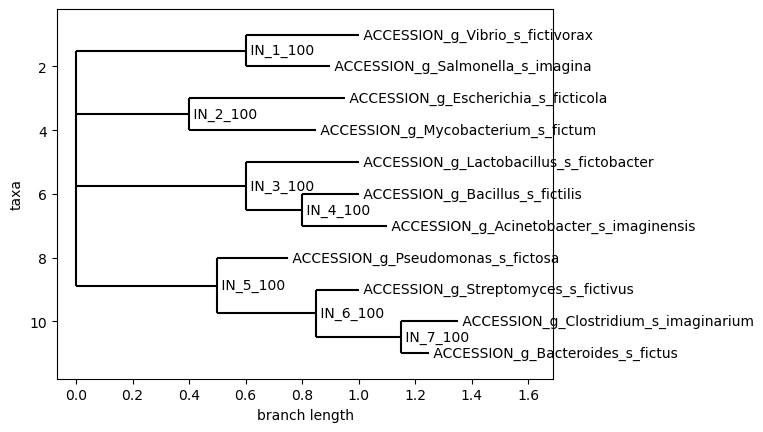

In [138]:
Phylo.draw(TREE)

## Conclusions so far
There seems to be 3 clusters:
1. The first cluster contains orgnaisms whose habitat has a normal temperature and high pH
2. The second cluster corresponds to organisms that live in low temps and low pH
3. Last, the third cluster includes the rest of organisms.

## 4. Sample placement <a class="anchor" id="clustering"></a>
Please refer to SqueezeMeta for metagenomic placements in reference trees. Importantly, it will need to output a well formatted mastertable.

## 5. Compute k-tensors <a class="anchor" id="compute-ktensors"></a>